# Video Actor Synchroncy and Causality (VASC)
## RAEng: Measuring Responsive Caregiving Project
### Caspar Addyman, 2020
### https://github.com/infantlab/VASC

# Step 3: Analyse the data using SyncPy

This script uses output from  human figure recognition neural network to create labeled wireframes for each figure in each frame of a video. 
In this step we start with a clean numpy array of all [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) data from all pairs of individuals. We then use [SyncPy](https://github.com/syncpy/SyncPy) for data analysis. SyncPy was developed by Giovanna Varni, Mohamed Chetouani and colleagues at the Institut des Systèmes Intelligentes et Robotique (ISIR) at the Université Pierre et Marie Curie (UPMC), Paris 6, France.  

A technical paper is found here: [Varni et al. (2015)](https://dl.acm.org/doi/10.1145/2823513.2823520)

 

**NOTE:**
At present (June 2020) the official version of SyncPy is written in Python2 format. Therefore, we have forked it and created a Python3 compatible version at https://github.com/InfantLab/SyncPy



In [1]:
import sys
import os
import json
import numpy as np       
import pandas as pd
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
%matplotlib inline

import logging
import ipywidgets as widgets  #let's us add buttons and sliders to this page.
from ipycanvas import Canvas

import vasc #a module of our own functions (found in vasc.py in this folder)

#turn on debugging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%pdb on

Automatic pdb calling has been turned ON


In [2]:
jupwd =  os.getcwd() + "\\"
projectpath = os.getcwd() + "\\..\\SpeakNSign\\"
# projectpath = os.getcwd() + "\\..\\lookit\\"

# locations of videos and output
videos_in = projectpath 
videos_out   = projectpath + "out"
#videos_out = "E:\\SpeakNSign\\out"
videos_out_openpose   = videos_out + "\\openpose"
videos_out_timeseries = videos_out + "\\timeseries"
videos_out_analyses   = videos_out + "\\analyses"

### 3.1 Load the clean data as a DataFrame

Reload the clean data file created in step 2. 

In [3]:
#retrieve the list of base names of processed videos.
try:
    with open(videos_out + '\\clean.json') as json_file:
        videos = json.load(json_file)
        print("Existing clean.json found..")
except:
    print("File clean.json not found.")

Existing clean.json found..


In [4]:
print('reading parquet file:')
df = pq.read_table(videos_out_timeseries + '\\cleandata.parquet').to_pandas()

#sort the column names as this helps with indexing
df = df.sort_index(axis = 1)
print(df.head())

reading parquet file:
video     SS003                                                          \
person   infant                                                           
coord        0        1         2        3        4         5        6    
0       556.540  356.132  0.899432  555.002  395.181  0.469440  547.184   
1       555.026  356.080  0.761866  556.577  390.507  0.352666  545.625   
2         0.000    0.000  0.000000    0.000    0.000  0.000000    0.000   
3       556.507  354.526  0.722555  553.467  395.316  0.331564  556.561   
4         0.000    0.000  0.000000    0.000    0.000  0.000000    0.000   

video                               ...  SS098                                \
person                              ... parent                                 
coord        7         8        9   ...     65   66   67   68   69   70   71   
0       382.758  0.336208  515.839  ...    0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       379.606  0.275334  531.538  ...    0.0  0.0  0.0 

## 3.2 Process the data 

Next we set all 0 values to as missing value `np.nan` to enable interpolation.
Then use numpy's built in `interpolate` method. 

In [5]:
df = df.replace(0.0, np.nan)

#are we going to use all the data or a subset?
first = 501
last = 8500

df = df.truncate(before  = first, after = last)

In [6]:
df = df.interpolate()

In [ ]:
df.shape

In [ ]:
print(df.head())

### 3.2.1 Mean movements
We create a dictionary of the subsets of OpenPose coordinates we want to average and then call `mean` on the Pandas dataframe. e.g.

```
meanpoints = {
               "headx" : [0, 3, 45, 48, 51, 54],
               "heady" : [1, 4, 46, 49, 52, 55],
               "allx" :  [0, 3, 6, 9, ...],
               "ally" :  [1, 4, 7, 10, ...]
             }
```

Then we call the `vasc.averageCoordinateTimeSeries` function to average across sets of coordinates. For a given set of videos and people.

In:
```
videos = "All"
people = "Both"
df2 = vasc.averageCoordinateTimeSeries(df,meanpoints,videos,people)
df2.head
```

Out:
```
person      infant                                          parent   
avgs         headx       heady          xs          ys       headx   
501     565.996600  369.840600  534.895615  398.482538  471.686200   
502     567.231800  369.887600  534.354198  398.706552  471.849400   
503     567.228600  370.159600  534.444328  398.678133  471.711600   
504     566.912600  369.857000  535.369536  398.551636  472.309400
...            ...         ...         ...         ...         ...
```


In [ ]:
meanpoints = {"headx" : vasc.headx,
              "heady" : vasc.heady,
              "armsx" : vasc.armsx,
              "armsy" : vasc.armsy,
              "allxs" : vasc.xs, 
              "allys": vasc.ys}

vids = "All"
people = ["infant","parent"]

df2 = vasc.averageCoordinateTimeSeries(df,meanpoints,vids,people)

df2.head

### 3.2.2 Rolling window of movements

One thing we'd like to know is if mothers move in response to infants. The raw time series are probably too noisy to tell us this so instead we look at the variance of movement over a short rolling window. 

First we apply 2 second long (50 frame) rolling window to each coordinate of the body and use the stddev or variance function `std()` or `var()` . Then we take averages as in the step above. 

However, this time we combine x and y coordinates as this is now a movement index.

In [7]:
df3 = df.rolling(window = 50, min_periods = 25).var()
# cut out the empty bits at the start
df3 = df3.truncate(before  = first + 50, after = last)

vids = "All"
people = ["infant","parent"]
meanpoints = {"head" : vasc.headxys,
              "arms" : vasc.armsxys,
              "all"  : vasc.xys}

df3 = vasc.averageCoordinateTimeSeries(df3,meanpoints,vids,people)

In [12]:
df3.head

<bound method NDFrame.head of video      SS003                                                         \
person    infant                          parent                          
avgs        head       arms        all      head       arms         all   
551     3.157980  58.178221  43.093422  7.990489  50.403186   39.278591   
552     3.555957  57.882548  43.463469  7.702251  50.835776   39.158491   
553     3.579744  57.278181  43.453991  7.367317  51.267203   39.050754   
554     3.605351  60.081149  44.389505  6.973763  51.827114   38.783952   
555     3.636811  59.609338  44.221724  6.579082  52.396502   38.975089   
...          ...        ...        ...       ...        ...         ...   
8496    5.341766  31.485880  43.465890  1.868973  79.784599  245.879375   
8497    5.194435  30.638536  42.487818  1.874666  75.686085  248.576143   
8498    5.032010  30.896221  41.651979  1.944470  73.436081  257.051322   
8499    5.001888  30.526521  40.789666  2.033981  83.523173  258.30119

### 3.3 Movement analysis

We need to let Jupyter know where to find SyncPy and then import the functions we need.


In [8]:
sys.path.insert(0, '..\\SyncPy\\src\\')   # To be able to import packages from parent directory
sys.path.insert(0, '..\\SyncPy\\src\\Methods')

In [9]:
""" Import wanted module with every parent packages """
import Methods.DataFrom2Persons.Univariate.Continuous.Linear.Correlation as Correlation

""" Import Utils modules """
from Methods.utils import Standardize
from Methods.utils import ResampleAndInterpolate
from Methods.utils.ExtractSignal import ExtractSignalFromCSV

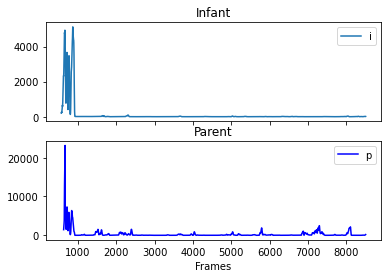

<class 'pandas.core.frame.DataFrame'>


In [10]:
n=np.arange(first+50,last+1)#number of samples


"""Plot input signals"""
plt.ion()
f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Infant')
axarr[1].set_title('Parent')
#axarr[0].set_xlabel('Frames')
axarr[1].set_xlabel('Frames')

vid = 'SS088'
who = ["infant","parent"]
part = ["head","arms","all"]

#to select a single column..
infant = df3[(vid, who[0], 'head')].to_frame()
parent = df3[(vid, who[1], 'head')].to_frame()

#selecting multiple columns slightly messier
#infant = df3.loc[50:,(vid, part[0], ('head','arms', 'all'))]
#parent = df3.loc[50:,(vid, part[1], ('head','arms', 'all'))]

axarr[0].plot(n,infant , label="i")
axarr[1].plot(n,parent, label="p", color='b')
axarr[0].legend(loc='best')
axarr[1].legend(loc='best')


plt.show() 
print(type(infant))

In [13]:
infant = df3[(vid, who[0], 'head')].to_frame()
infant.head
print(type(infant))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
""" Define class attributes of the wanted method """

tau_max = 100                       # the maximum lag at which correlation should be computed (in samples)
plot=True                           # plot of the correlation fucntion
standardization = True              # standardization of the time series to mean 0 and variance 1
corr_tau_max = True                 # return of the maximum of correlation and its lag
corr_coeff = True                   # computation of the correlation coefficient (Pearson's version)
scale=True                          # scale factor to have correlaton in [-1,1]

""" Instantiate the class with its attributes """
print("\n")

try : 
    c=Correlation.Correlation(tau_max, plot, standardization, corr_tau_max, corr_coeff, scale)
except TypeError as err :
    print("TypeError in Correlation constructor : \n" + str(err))
    sys.exit(-1)
except ValueError as err :
    print("ValueError in Correlation constructor : \n" + str(err))
    sys.exit(-1)
except Exception as e :
    print("Exception in Correlation constructor : \n" + str(e))
    sys.exit(-1)

print("An instance the class is now created with the following parameters:\n" +
      "tau max = " + str(tau_max) + "\n" +
      "plot = " + str(plot) + "\n" +
      "standardization= " + str(standardization) + "\n" +
      "corr_tau_max = " + str(corr_tau_max) + "\n" +
      "corr_coeff =" + str(corr_coeff) +"\n" +
      "scale =" + str(scale))

""" Compute the method and get the result """
print("\n")
print("Computing...")


try : 
    res= c.compute([infant,parent ])
except TypeError as err :
    print("TypeError in Correlation computation : \n" + str(err))
    sys.exit(-1)
except ValueError as err :
    print("ValueError in Correlation computation : \n" + str(err))
    sys.exit(-1)
except Exception as e :
    print("Exception in Correlation computation : \n" + str(e))
    sys.exit(-1)

""" Display result """
print("\n")
print("**************************************** \n")
print('Correlation complete result :')
print("****************************************\n")
print("Correlation function array:")
print(res['corr_funct'])
print("Maximum value of the correlation %f and lag (in samples) %d:" %(res['max_corr'],res['t_max']))
print("Pearson's correlation coefficient %f:" %(res['corr_coeff']))

In [14]:
tau_max = 100                       # the maximum lag at which correlation should be computed (in samples)
plot=False                           # plot of the correlation fucntion
standardization = True              # standardization of the time series to mean 0 and variance 1
corr_tau_max = True                 # return of the maximum of correlation and its lag
corr_coeff = True                   # computation of the correlation coefficient (Pearson's version)
scale=True                          # scale factor to have correlaton in [-1,1]

try : 
    c=Correlation.Correlation(tau_max, plot, standardization, corr_tau_max, corr_coeff, scale)
except TypeError as err :
    print("TypeError in Correlation constructor : \n" + str(err))
    sys.exit(-1)
except ValueError as err :
    print("ValueError in Correlation constructor : \n" + str(err))
    sys.exit(-1)
except Exception as e :
    print("Exception in Correlation constructor : \n" + str(e))
    sys.exit(-1)


parts = ["head","arms","all"]
results = pd.DataFrame(columns = ("corrHead","lagHead","corrArms","lagArms","corrAll","lagAll","DyadSynScore"),
                      index = videos)

In [15]:
#loop through colcuate for each pair
for vid in videos:
    print(vid)
    who = ["infant","parent"]
    thisrow = []
    for part in parts:
        #to select a single column..
        infant = df3[(vid, who[0], part)].to_frame()
        parent = df3[(vid, who[1], part)].to_frame()

        try : 
            res= c.compute([infant, parent])
        except TypeError as err :
            print("TypeError in Correlation computation : \n" + str(err))
            sys.exit(-1)
        except ValueError as err :
            print("ValueError in Correlation computation : \n" + str(err))
            sys.exit(-1)
        except Exception as e :
            print("Exception in Correlation computation : \n" + str(e))
            sys.exit(-1)
        
        #record results
        #print(part)
        #print("Pearson's corr : %f" %(res['corr_coeff']))
        #print("Maximum offset : %d" %(res['t_max']))
        thisrow.append(res['corr_coeff'])
        thisrow.append(res['t_max'])
    
    thisrow.append(None) #don't have DyadSynScore yet 
    results.loc[vid] = thisrow

SS003
SS010
SS013
SS015
SS016
SS017
SS020
SS021
SS022
SS023
SS030
SS033
SS035
SS036
SS041
SS044
SS045
SS048
SS053
SS054
SS057
SS065
SS068
SS070
SS084
SS085
SS095
SS096
SS097
SS098
SS004
SS005
SS007
SS009
SS024
SS026
SS028
SS029
SS043
SS050
SS051
SS052
SS059
SS064
SS066
SS067
SS069
SS071
SS074
SS075
SS081
SS083
SS088


In [16]:
results

,corrHead,lagHead,corrArms,lagArms,corrAll,lagAll,DyadSynScore
SS003,0.69075,-1,0.715597,0,0.842764,1,None
SS010,0.898288,1,0.911389,1,0.91779,1,None
SS013,0.939197,0,0.964649,0,0.957817,0,None
SS015,0.688211,0,0.910355,-1,0.914989,1,None
SS016,0.63266,0,0.907649,0,0.89296,0,None
SS017,0.92209,0,0.893251,0,0.737473,-1,None
SS020,0.922935,0,0.88746,0,0.929818,0,None
SS021,0.646211,1,0.772365,-1,0.829454,0,None
SS022,0.733876,-1,0.765336,0,0.820823,1,None
SS023,0.90116,1,0.930776,1,0.976773,0,None


In [29]:
excelpath = projectpath + "\\SS_CARE.xlsx"
videolist = pd.read_excel(excelpath)
videolist = videolist.set_index("subject")


In [30]:
videolist

,camera1,camera2,camera3,Group,Include,swapped,cambest,camnext,camworst,Karolina comments,...,MatContIRR,MatUnrIRR,InfCoopIRR,InfCompIRR,InfDiffIRR,InfPassiveIRR,Household_CAT,DS_CATS,filter_$,DS_CATS2
subject,,,,,,,,,,,,,,,,,,,,,
SS003,U:\Toddler_videos\SS003\SS003_13314_1.mp4,U:\Toddler_videos\SS003\SS003_13314_2.mp4,U:\Toddler_videos\SS003\SS003_13314_3.mp4,0,True,True,camera2,camera3,camera1,+ SS003 - Camera 2 -- fully cleaned - there's...,...,0.0,6.0,6.0,0.0,8.0,0.0,1.0,3,0,2
SS010,U:\Toddler_videos\SS010\PCI_SS010_1.mp4,U:\Toddler_videos\SS010\PCI_SS010_2.mp4,U:\Toddler_videos\SS010\PCI_SS010_3.mp4,0,True,False,camera1,camera2,camera3,+ SS010 - Camera 1 -- mostly cleaned - there ...,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0,1
SS013,U:\Toddler_videos\ss013\CAM1_20140515-103645.mp4,U:\Toddler_videos\ss013\CAM2_20140515-103645.mp4,U:\Toddler_videos\ss013\CAM3_20140515-103645.mp4,0,True,False,camera1,camera2,camera3,SS013 - Camera 2 -- fully cleaned - after remo...,...,0.0,7.0,9.0,0.0,0.0,5.0,3.0,2,0,1
SS015,U:\Toddler_videos\SS015\SS015_PCI1.mp4,U:\Toddler_videos\SS015\SS015_PCI2.mp4,U:\Toddler_videos\SS015\SS015_PCI3.mp4,0,True,True,camera3,camera2,camera1,SS015 - Camera 1 -- partly cleaned- had many f...,...,0.0,8.0,4.0,1.0,3.0,6.0,3.0,1,0,1
SS016,U:\Toddler_videos\SS016\SS016_PCI1.mp4,U:\Toddler_videos\SS016\SS016_PCI2.mp4,U:\Toddler_videos\SS016\SS016_PCI3.mp4,0,True,False,camera1,camera2,camera3,+ SS016 - Camera 1 -- fully cleaned,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1,0,1
SS017,U:\Toddler_videos\SS017\SS017-pci1.mp4,U:\Toddler_videos\SS017\SS017-pci2.mp4,U:\Toddler_videos\SS017\SS017-pci3.mp4,0,True,False,camera1,camera2,camera3,+ SS017 - Camera 1 -- fully cleaned - start ar...,...,1.0,6.0,5.0,0.0,3.0,6.0,3.0,2,0,1
SS020,U:\Toddler_videos\SS020\SS020_PCI_1.mp4,U:\Toddler_videos\SS020\SS020_PCI_2.mp4,U:\Toddler_videos\SS020\SS020_PCI_3.mp4,0,True,True,camera3,camera1,camera2,SS020 - Camera 3 -- fully cleaned - lots of mi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,1
SS021,U:\Toddler_videos\SS021\SS021_PCI_1.mp4,U:\Toddler_videos\SS021\SS021_PCI_2.mp4,U:\Toddler_videos\SS021\SS021_PCI_3.mp4,0,True,False,camera1,NaN,NaN,+ SS021 - Camera 1 -- fully cleaned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
SS022,U:\Toddler_videos\SS022\CAM1_20140624-133628.mp4,U:\Toddler_videos\SS022\CAM2_20140624-133629.mp4,U:\Toddler_videos\SS022\CAM3_20140624-133629.mp4,0,True,True,camera3,camera1,camera2,+ SS022 - Camera 3 -- fully cleaned,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0,1


In [34]:

results["DyadSynScore"] = videolist["DyadSyn"]
results["MatSensScore"] = videolist["MatSens"]

In [35]:
results

,corrHead,lagHead,corrArms,lagArms,corrAll,lagAll,DyadSynScore,MatSensScore
SS003,0.69075,-1,0.715597,0,0.842764,1,6,6
SS010,0.898288,1,0.911389,1,0.91779,1,12,13
SS013,0.939197,0,0.964649,0,0.957817,0,8,7
SS015,0.688211,0,0.910355,-1,0.914989,1,12,13
SS016,0.63266,0,0.907649,0,0.89296,0,14,13
SS017,0.92209,0,0.893251,0,0.737473,-1,8,6
SS020,0.922935,0,0.88746,0,0.929818,0,9,10
SS021,0.646211,1,0.772365,-1,0.829454,0,13,14
SS022,0.733876,-1,0.765336,0,0.820823,1,12,13
SS023,0.90116,1,0.930776,1,0.976773,0,13,14


In [39]:
savepath = projectpath + "\\syncpy.results.xlsx"
results.to_excel(savepath)

## 3.4 Granger Causality

The next thing to look at is if the movements of the infant predict the movements of the parent. This would suggest parent is responding to the infant. 


In [ ]:

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

https://www.machinelearningplus.com/time-series/time-series-analysis-python/